In [1]:
from utils import *
from MySolution import MyClassifier, MyClustering, MyLabelSelection

In [2]:
%load_ext autoreload
%autoreload 2

Synthetic data shape:  (1000, 2) (1000,)


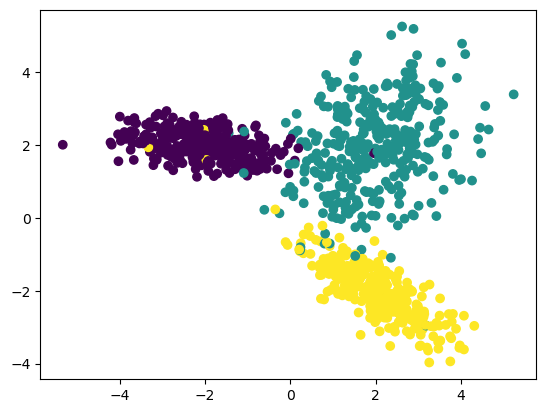

In [3]:
# Get datasets
syn_data = prepare_synthetic_data()
print("Synthetic data shape: ", syn_data['trainX'].shape, syn_data['trainY'].shape)

plt.scatter(syn_data['trainX'][:, 0], syn_data['trainX'][:, 1], c=syn_data['trainY'])

MNIST data shape:  (1000, 784) (1000,)


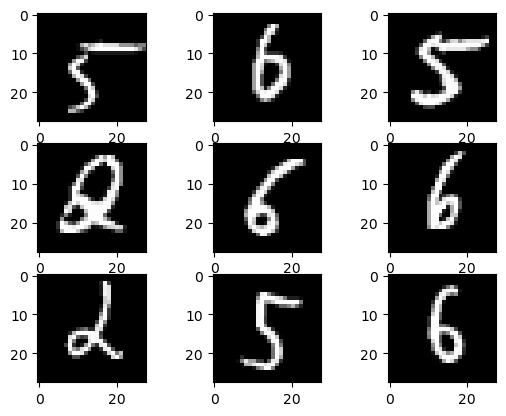

In [4]:
mnist_data = prepare_mnist_data()
print("MNIST data shape: ", mnist_data['trainX'].shape, mnist_data['trainY'].shape)

for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(mnist_data['trainX'][i].reshape(28,28), cmap='gray')
plt.show()

In [59]:
syn_data["trainX"] + 4

array([[6.45836059, 6.33615717],
       [7.0969569 , 0.93636804],
       [6.79162577, 6.89981478],
       ...,
       [5.51968087, 2.95278262],
       [3.77140398, 5.71856747],
       [5.16551569, 4.85537577]])

In [60]:
syn_data["trainX"] = syn_data["trainX"] + 4
syn_data["testX"] +=4

classifier_syn = MyClassifier(K=len(set(syn_data["trainY"])))
classifier_mnist = MyClassifier(K=len(set(mnist_data["trainY"])))

classifier_syn.train(syn_data)
classifier_mnist.train(mnist_data)

result1 = {
    'synthetic_test_accuracy':classifier_syn.evaluate(syn_data["testX"], syn_data["testY"]), 
    'mnist_test_accuracy':classifier_mnist.evaluate(mnist_data["testX"], mnist_data["testY"])
}

In [6]:
result1

{'synthetic_test_accuracy': 0.966, 'mnist_test_accuracy': 0.0}

In [99]:
result2 = {
    'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[], 'classification_accuracy':[]},
    'mnist':{'K':[3, 10, 32], 'clustering_nmi':[], 'classification_accuracy':[]}
}

In [107]:
for K in result2["synthetic"]["K"]:
    cluster_syn = MyClustering(K)
    cluster_syn.train(syn_data["trainX"], maxiter=30)
    cluster_syn.align_labels(syn_data["trainY"])
    result2["synthetic"]['clustering_nmi'].append(cluster_syn.evaluate_clustering(syn_data["trainY"]))
    cluster_syn.align_labels(syn_data["trainY"])
    result2["synthetic"]['classification_accuracy'].append(
       cluster_syn.evaluate_classification(syn_data["testX"], syn_data["testY"])
    )

train acc is:  0.652
train acc is:  0.652
train acc is:  0.945


In [111]:
# strongly recommend to first perform PCA to reduce the dimension
# sparse-NMF takes **very long** to solve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

std = StandardScaler()
pca = PCA(n_components=70)
trainX_std = std.fit_transform(mnist_data["trainX"])
testX_std = std.transform(mnist_data["testX"])
trainX_pca = pca.fit_transform(trainX_std)
testX_pca = pca.transform(testX_std)

# to feed into sparseNMF, we need to make our datapoints none-negative
nn = MinMaxScaler()
trainX_nn = nn.fit_transform(trainX_pca)
testX_nn = nn.transform(testX_pca)

In [113]:
for K in result2["mnist"]["K"]:
    cluster_mnist = MyClustering(K)
    cluster_mnist.train(trainX_nn)
    cluster_mnist.align_labels(mnist_data["trainY"])
    result2["mnist"]['clustering_nmi'].append(cluster_mnist.evaluate_clustering(mnist_data["trainY"]))
    result2["mnist"]['classification_accuracy'].append(
        cluster_mnist.evaluate_classification(testX_nn, mnist_data["testY"])
    )

train acc is:  0.586
train acc is:  0.72
train acc is:  0.873


In [114]:
result2

{'synthetic': {'K': [3, 5, 10],
  'clustering_nmi': [0.8316895315697408,
   0.6124551949010293,
   0.44343977239242366,
   0.8346614954173779,
   0.5417879848554709,
   0.47610681096069474,
   0.7882402761361345],
  'classification_accuracy': [0.316, 0.314, 0.316, 0.678, 0.674, 0.68]},
 'mnist': {'K': [3, 10, 32],
  'clustering_nmi': [0.5954662704144004,
   0.7082162044388366,
   0.840374169443581,
   0.2412712300106492,
   0.3018412934577027,
   0.5878081750411801],
  'classification_accuracy': [0.712, 0.914, 0.93, 0.542, 0.75, 0.848]}}

In [21]:
result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[], 'test_accuracy(random)':[]},
            'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[], 'test_accuracy(random)':[]}}

In [22]:
for p in result3["synthetic"]["label_percentage"]:
    classifier = MyClassifier(K=len(set(syn_data["trainY"])))
    selecter = MyLabelSelection(ratio=p)

    sel = selecter.select(syn_data["trainX"])
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(our algo)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))
    
    n, _ = syn_data["trainX"].shape
    sel = np.random.randint(0, n, size=int(n*p))
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(random)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))

100%|███████████████████████████████████████████████████████████████████████| 999/999 [00:25<00:00, 38.70it/s]


In [23]:
for p in result3["synthetic"]["label_percentage"]:
    classifier = MyClassifier(K=len(set(syn_data["trainY"])))
    selecter = MyLabelSelection(ratio=p)

    sel = selecter.select(syn_data["trainX"])
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(our algo)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))
    
    n, _ = syn_data["trainX"].shape
    sel = np.random.randint(0, n, size=int(n*p))
    sel_data = {"trainX": syn_data["trainX"][sel, :], "trainY": syn_data["trainY"][sel]}
    classifier.train(sel_data)
    result3["synthetic"]["test_accuracy(random)"].append(classifier.evaluate(syn_data["testX"], syn_data["testY"]))

{'synthetic': {'label_percentage': [0.05, 0.1, 0.2, 0.5, 1],
  'test_accuracy(our algo)': [0.904, 0.834, 0.848, 0.852, 0.874],
  'test_accuracy(random)': [0.65, 0.92, 0.834, 0.892, 0.868]},
 'mnist': {'label_percentage': [0.05, 0.1, 0.2, 0.5, 1],
  'test_accuracy(our algo)': [],
  'test_accuracy(random)': []}}

In [25]:
## TODO: Implement your solution and store the results in the following dictionaries
## Please note that the below values are given as an example to show the format, 
## you need to replace them with your values :)
classifier = MyClassifier(K=len(set(trainY)))

result1 = {'synthetic_test_accuracy':0.9, 'mnist_test_accuracy':0.85}

result2 = {'synthetic':{'K':[3, 5, 10], 'clustering_nmi':[0.6,0.6,0.6], 'classification_accuracy':[0.8,0.8,0.8]},
            'mnist':{'K':[3, 10, 32], 'clustering_nmi':[0.5,0.5,0.5], 'classification_accuracy':[0.7,0.7,0.7]}}
                                
result3 = {'synthetic': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.6,0.7,0.8,0.9], 'test_accuracy(random)':[0.4,0.5,0.6,0.7,0.8]},
            'mnist': {'label_percentage':[0.05,0.1,0.2,0.5,1], 'test_accuracy(our algo)':[0.5,0.5,0.7,0.7,0.7], 'test_accuracy(random)':[0.4,0.4,0.6,0.6,0.6]}}


plot_result(result1, result2, result3)

NameError: name 'trainY' is not defined

In [92]:
mnist_data

{'trainX': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'trainY': array([5., 6., 5., 2., 6., 6., 2., 5., 6., 6., 5., 5., 6., 5., 2., 6., 5.,
        6., 2., 2., 5., 6., 5., 2., 2., 6., 2., 5., 6., 2., 5., 2., 6., 2.,
        5., 6., 2., 5., 6., 6., 2., 6., 5., 5., 5., 5., 2., 6., 2., 5., 6.,
        6., 2., 2., 5., 6., 2., 2., 2., 2., 5., 5., 5., 5., 6., 5., 6., 2.,
        2., 6., 2., 2., 6., 6., 2., 2., 6., 5., 6., 6., 2., 6., 5., 6., 6.,
        6., 6., 2., 6., 2., 5., 6., 2., 6., 5., 6., 6., 2., 2., 5., 2., 2.,
        5., 6., 2., 2., 6., 6., 5., 5., 6., 5., 6., 5., 2., 6., 5., 2., 2.,
        2., 2., 2., 5., 6., 6., 2., 6., 5., 5., 2., 2., 6., 2., 6., 6., 5.,
        6., 6., 6., 6., 2., 5., 5., 2., 2., 2., 6., 5., 2., 6., 6., 6., 5.,
        2., 5., 5., 2., 5., 6., 2., 6., 2., 5.,

In [84]:
A = np.array([[1, 2, 3], [0, 1, 3], [1, 3, 1]]).T
print(A)
b = np.array([0, 1, 3])

[[1 0 1]
 [2 1 3]
 [3 3 1]]


In [90]:
np.linalg.norm(A.T - b, axis=0)

array([1.41421356, 2.23606798, 2.        ])

In [88]:
from MySolution import *
solve_l2_Ax_b_dist(A, b)

array([0., 1., 0.])